<a href="https://colab.research.google.com/github/advaitkumar3107/GNR-652-Project/blob/master/Edge_Connect_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
from random import randint
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from scipy import ndimage
from scipy.ndimage.filters import convolve
from scipy import misc
import scipy.misc as sm
from skimage.feature import canny
from IPython.display import HTML
from google.colab import drive 
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/
import model
device = 'cuda'
np.random.seed(1)
torch.cuda.empty_cache()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive


In [0]:
def rgbtogray(image): #function that converts an rgb to grayscale image
  r,g,b = image[:,0,:,:], image[:,1,:,:], image[:,2,:,:]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  gray = gray.unsqueeze_(1)
  return gray

def regular_mask_grayscale(img,random_num):  #function that creates a square mask randomly that masks 25% of the image pixels
  k = 0
  b_size = img.size(0)
  mask_1 = torch.zeros((b_size,1,256,256))
  masked_image_1 = torch.zeros((b_size,1,256,256))
  for image in img:
    masked_image = image.squeeze_(0)*1
    rand = random_num
    mask = torch.zeros((256,256))
    for i in range(rand-10,rand+11):
      for j in range(rand-10,rand+11):
        masked_image[i][j] = 1.0
        mask[i][j] = 1.0
    masked_image = masked_image.unsqueeze_(0)
    mask = mask.unsqueeze_(0)
    mask_1[k,:,:,:] = mask
    masked_image_1[k,:,:,:] = masked_image
    k = k+1
  return masked_image_1,mask_1

def irregular_mask(img):  #function that randomly masks 30% of the image pixels
  mask = np.zeros((256,256))
  for i in range(140):
    for j in range(140):
      mask[i][j] = 1.0
  mask = mask.ravel()
  np.random.shuffle(mask)
  mask = mask.reshape((1,256,256))
  masked_img = img*1
  masked_img = np.maximum(masked_img,mask)
  return masked_img, mask

def gram_matrix(image):

  b,ch, h, w = image.size()
  f = image.view(b,ch, w * h)
  f_T = f.transpose(1,2)
  G = f.bmm(f_T) / (h * w * ch)

  return G

def canny_edge_detector(image):
  b_size = image.size(0)
  temp1 = torch.zeros((b_size,1,256,256))
  i = 0
  for images in image:
    temp = images.squeeze_(0)
    canny_edge = canny(temp.cpu().numpy())
    canny_edge = torch.from_numpy(canny_edge).unsqueeze_(0)
    temp1[i,:,:,:] = canny_edge
    i = i+1
  return temp1

In [0]:
##### MODEL ARCHITECTURES #########

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms


class residual_block_edge(nn.Module):
  def __init__(self,ngpu):
    super(residual_block_edge,self).__init__()
    self.ngpu = ngpu
    self.layer1 = nn.Sequential(nn.ReflectionPad2d(1), nn.utils.spectral_norm(nn.Conv2d(256,256,3,1,padding = 0)), nn.InstanceNorm2d(256), nn.ReLU(True))
    self.layer2 = nn.Sequential(nn.ReflectionPad2d(1), nn.utils.spectral_norm(nn.Conv2d(256,256,3,1,padding = 0)), nn.InstanceNorm2d(256))

  def forward(self,x):
    y = self.layer1(x)
    y = self.layer2(y)
    out = x + y
    return out



class residual_block_completion(nn.Module):
  def __init__(self,ngpu):
    super(residual_block_completion,self).__init__()
    self.ngpu = ngpu
    self.layer1 = nn.Sequential(nn.ReflectionPad2d(1),nn.Conv2d(256,256,3,1,padding = 0), nn.InstanceNorm2d(256), nn.ReLU(True))
    self.layer2 = nn.Sequential(nn.ReflectionPad2d(1),nn.Conv2d(256,256,3,1,padding = 0), nn.InstanceNorm2d(256))

  def forward(self,x):
    y = self.layer1(x)
    y = self.layer2(y)
    out = x + y
    return out




class generator1(torch.nn.Module):
  def __init__(self, ngpu):
    super(generator1,self).__init__()
    self.ngpu = ngpu
    self.c64 = nn.Sequential(nn.ReflectionPad2d(3),nn.utils.spectral_norm(nn.Conv2d(3,64,7,1, padding = 0)), nn.InstanceNorm2d(64), nn.ReLU(True))
    self.d128 = nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(64,128,4,2,padding = 1)), nn.InstanceNorm2d(128),nn.ReLU(True))
    self.d256 = nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(128,256,4,2,padding =1)), nn.InstanceNorm2d(256),nn.ReLU(True))
    self.r256 = residual_block_edge(ngpu)
    self.u128 = nn.Sequential(nn.utils.spectral_norm(nn.ConvTranspose2d(256,128,4,2,padding = 1)), nn.InstanceNorm2d(128), nn.ReLU(True))
    self.u64 = nn.Sequential(nn.utils.spectral_norm(nn.ConvTranspose2d(128,64,4,2,padding = 1)), nn.InstanceNorm2d(64), nn.ReLU(True))
    self.out = nn.Sequential(nn.ReflectionPad2d(3), nn.utils.spectral_norm(nn.Conv2d(64,1,7,1, padding = 0)))

  def forward(self,x):
    x = self.c64(x)
    x = self.d128(x)
    x = self.d256(x)

    for i in range(8):
      x = self.r256(x)
    
    x = self.u128(x)
    x = self.u64(x)
    x = self.out(x)
    out = torch.sigmoid(x)
    return out




class generator2(torch.nn.Module):
  def __init__(self,ngpu):
    super(generator2,self).__init__()
    self.ngpu = ngpu
    self.c64 = nn.Sequential(nn.ReflectionPad2d(3),nn.Conv2d(4,64,7,1,padding = 0), nn.InstanceNorm2d(64), nn.ReLU(True))
    self.d128 = nn.Sequential(nn.Conv2d(64,128,4,2,padding = 1),nn.InstanceNorm2d(128),nn.ReLU(True))
    self.d256 = nn.Sequential(nn.Conv2d(128,256,4,2,padding = 1),nn.InstanceNorm2d(256),nn.ReLU(True))
    self.r256 = residual_block_completion(ngpu)
    self.u128 = nn.Sequential(nn.ConvTranspose2d(256,128,4,2,padding = 1), nn.InstanceNorm2d(128), nn.ReLU(True))
    self.u64 = nn.Sequential(nn.ConvTranspose2d(128,64,4,2,padding = 1),nn.InstanceNorm2d(64), nn.ReLU(True))
    self.out = nn.Sequential(nn.ReflectionPad2d(3), nn.Conv2d(64,3,7,1,padding = 0))

  def forward(self,x):
    x = self.c64(x)
    x = self.d128(x)
    x = self.d256(x)

    for i in range(8):
      x = self.r256(x)

    x = self.u128(x)
    x = self.u64(x)
    x = self.out(x)
    out = torch.tanh(x)
    return out

class discriminator(torch.nn.Module):
  def __init__(self,in_channels,ngpu):
    super(discriminator,self).__init__()
    self.ngpu = ngpu
    self.c1 = nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(in_channels,64,4,2,padding = 1)), nn.LeakyReLU(0.2))
    self.c2 = nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(64,128,4,2,padding = 1)), nn.LeakyReLU(0.2))
    self.c3 = nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(128,256,4,2,padding = 1)), nn.LeakyReLU(0.2))
    self.c4 = nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(256,512,4,1,padding = 1)), nn.LeakyReLU(0.2))
    self.c5 = nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(512,1,4,1,padding = 1)))

  def forward(self,x):
    c1 = self.c1(x)
    c2 = self.c2(c1)
    c3 = self.c3(c2)
    c4 = self.c4(c3)
    c5 = self.c5(c4)
    out = torch.sigmoid(c5)
    return out, [c1, c2, c3, c4, c5]



class Vgg19(torch.nn.Module):
    def __init__(self):
        super(Vgg19, self).__init__()
        features = list(torchvision.models.vgg19(pretrained = True).features)[:31]
        self.features = nn.ModuleList(features).eval() 
        
    def forward(self, x):
        results = []
        for ii,model in enumerate(self.features):
            x = model(x)
            if ii in {1,6,11,20,29}:
                results.append(x)
        return results




def weights_init(m):
  classname = m.__class__.__name__
  if hasattr(m, 'weight') and (classname.find('Conv') != -1):
    if hasattr(m, 'bias') and m.bias is not None:
      nn.init.constant_(m.bias.data, 0.0)
    else:
      nn.init.normal_(m.weight.data, 0.0, 0.02)

  elif classname.find('BatchNorm2d') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0.0)

In [0]:
dataset = dset.ImageFolder(root='celeba',
                           transform=transforms.Compose([
                               transforms.Resize(256),
                               transforms.CenterCrop(256),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [0]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset,test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [0]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 8, shuffle = True, num_workers = 2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 8, shuffle = True, num_workers = 2)

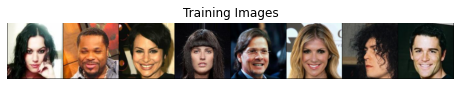

In [0]:
#Plot some training images
train_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(train_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

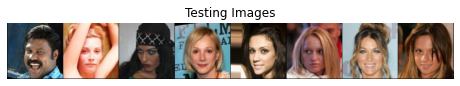

In [0]:
# Plot some testing images
test_batch = next(iter(test_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Testing Images")
plt.imshow(np.transpose(vutils.make_grid(test_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
"""
Creating the new models here for training and testing
"""

Edge_generator = generator1(1).to(device)
Inpaint_generator = generator2(1).to(device)
Edge_discriminator = discriminator(2,1).to(device)
feature_matching_discriminator = discriminator(1,1).to(device)
Inpaint_discriminator = discriminator(4,1).to(device)
vgg19 = Vgg19().to(device)

Edge_generator.load_state_dict(torch.load('Edge_generator.pt'))
Inpaint_generator.load_state_dict(torch.load('Inpaint_generator.pt'))
Edge_discriminator.load_state_dict(torch.load('Edge_discriminator.pt'))
Inpaint_discriminator.load_state_dict(torch.load('Inpaint_discriminator.pt'))

discriminator(
  (c1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (c2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (c3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (c4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (c5): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [0]:
epochs = 1
device = 'cuda'
#to keep track of the progress
G1_losses = []
D1_losses = []
G2_losses = []
D2_losses = []
iters = 0
lr = 0.0001
beta1 = 0
beta2 = 0.9
criterion = nn.BCELoss()
l1criterion = nn.L1Loss()

optimizer_edge_G = optim.Adam(Edge_generator.parameters(), lr=lr, betas = (beta1, beta2))
optimizer_edge_D = optim.Adam(Edge_discriminator.parameters(), lr=lr/10, betas=(beta1, beta2))
optimizer_inpaint_D = optim.Adam(Inpaint_discriminator.parameters(), lr=lr/10, betas=(beta1, beta2))
optimizer_inpaint_G = optim.Adam(Inpaint_generator.parameters(), lr=lr, betas=(beta1, beta2))

print('Beginning Training....')

for epoch in range(epochs):
  for i,data in enumerate(train_dataloader,0):
    """
    Updating the D1 network
    """    
    Edge_discriminator.train().zero_grad() #clearing the gradients

    real_cpu = data[0].to(device)  #the batch of images
    b_size = real_cpu.size(0)
    real_label = torch.full((b_size,1,30,30),1,device = device)  #label of ones
    fake_label = torch.full((b_size,1,30,30),0,device = device)  #label of zeros
 
    I_gray = rgbtogray(real_cpu).to(device)  #converting input image into grayscale
    C_gt = canny_edge_detector(I_gray) #edge map of the input image
    C_gt = C_gt.type(torch.FloatTensor).to(device)
    C_gt_1 = C_gt
    rand_num = np.random.randint(60,195)
    I_gray_masked,mask = regular_mask_grayscale(I_gray,rand_num) #masked grayscale input and mask
    I_gray_masked = I_gray_masked.type(torch.FloatTensor).to(device)
    mask = mask.to(device)
    C_gt_masked = canny_edge_detector(I_gray_masked)  #masked edge map
    C_gt_masked = C_gt_masked.type(torch.FloatTensor).to(device)
    edge_generator_input = torch.cat((I_gray_masked, C_gt_masked, mask),1)  #concatenating all the 3 inputs to form the final input to edge generator
    C_pred = Edge_generator(edge_generator_input)  #predicted edge map by generator, detaching so that gradients dont flow into the generator

    true = torch.cat((C_gt,I_gray),1).to(device)
    fake = torch.cat((C_pred,I_gray),1).to(device)

    true_probability, [c1,c2,c3,c4,c5] = Edge_discriminator(true)
    fake_probability, [d1,d2,d3,d4,d5] = Edge_discriminator(fake.detach())

    true_loss = criterion(true_probability, real_label)
    true_loss.backward()
    fake_loss = criterion(fake_probability, fake_label)
    fake_loss.backward()
    D1_loss = true_loss + fake_loss
    D1_losses.append(D1_loss)
    optimizer_edge_D.step()
    
    """
    Updating the G1 network
    """
    Edge_generator.train().zero_grad()

    C_pred = Edge_generator(edge_generator_input)  

    true_1 = C_gt_1
    fake_1 = C_pred

    true_probability_1, [c1,c2,c3,c4,c5] = feature_matching_discriminator(true_1)
    fake_probability_1, [d1,d2,d3,d4,d5] = feature_matching_discriminator(fake_1)

    #true_loss = criterion(true_probability_1, real_label)
    #fake_loss = criterion(fake_probability_1, fake_label)
    #edge_discriminator_loss = -(true_loss + fake_loss)

    fake_loss_updated = criterion(fake_probability_1,real_label).to(device)

    lfm_1 = l1criterion(c1,d1)
    lfm_2 = l1criterion(c2,d2)
    lfm_3 = l1criterion(c3,d3)
    lfm_4 = l1criterion(c4,d4)
    lfm_5 = l1criterion(c5,d5)
    lfm = lfm_1 + lfm_2 + lfm_3 + lfm_4 + lfm_5

    edge_generator_loss = 2*lfm + fake_loss_updated

    edge_generator_loss.backward()
    optimizer_edge_G.step()
    G1_losses.append(edge_generator_loss)

    """
    Updating the D2 network
    """
    Inpaint_discriminator.train().zero_grad()

    r = real_cpu[:,0,:,:].unsqueeze_(1).to(device)
    g = real_cpu[:,1,:,:].unsqueeze_(1).to(device)
    b = real_cpu[:,2,:,:].unsqueeze_(1).to(device)
    I_gt_r = np.maximum(r.cpu(),mask.cpu()).to(device)
    I_gt_b = np.maximum(b.cpu(),mask.cpu()).to(device)
    I_gt_g = np.maximum(g.cpu(),mask.cpu()).to(device)

    I_gt_masked = torch.cat((I_gt_r,I_gt_g,I_gt_b),1).to(device)
    
    
    C_pred_1 = C_pred.detach().to(device)
    I_gt = real_cpu.detach().to(device)
    C_comp = (C_gt_masked + (torch.ones((b_size,1,256,256)).to(device)-mask) * C_pred_1).to(device)
    generator2_input = torch.cat((I_gt_masked,C_comp),1).to(device)
    I_pred = Inpaint_generator(generator2_input).to(device)

    true_2 = torch.cat((I_gt,C_comp),1).to(device)
    fake_2 = torch.cat((I_pred,C_comp),1).to(device)

    true_probability_2, [c1,c2,c3,c4,c5] = Inpaint_discriminator(true_2)
    fake_probability_2, [d1,d2,d3,d4,d5] = Inpaint_discriminator(fake_2.detach())

    true_loss_1 = criterion(true_probability_2,real_label).to(device)
    true_loss_1.backward()
    fake_loss_1 = criterion(fake_probability_2,fake_label).to(device)
    fake_loss_1.backward()
    D2_loss = (true_loss_1 + fake_loss_1).to(device)
    optimizer_inpaint_D.step()
    D2_losses.append(D2_loss)

    """
    Updating the G2 network
    """
    Inpaint_generator.train().zero_grad()
    #L1 loss
    I_pred_1 = Inpaint_generator(generator2_input).to(device)
    inpaint_generator_loss = (1 * l1criterion(I_pred_1, I_gt)).to(device)
    

    #Adversarial Loss
    true_3 = torch.cat((I_gt,C_comp),1).to(device)
    fake_3 = torch.cat((I_pred_1,C_comp),1).to(device)

    true_probability_3, [c1,c2,c3,c4,c5] = Inpaint_discriminator(true_3)
    fake_probability_3, [d1,d2,d3,d4,d5] = Inpaint_discriminator(fake_3)

    #true_loss_2 = criterion(true_probability_3,real_label).to(device)
    #fake_loss_2 = criterion(fake_probability_3,fake_label).to(device)
    
    fake_loss_updated = criterion(fake_probability_3,real_label).to(device)
    #inpaint_discriminator_loss = - (true_loss_2 + fake_loss_2)
    
    inpaint_generator_loss = inpaint_generator_loss + 0.1 * fake_loss_updated

    
    #Perceptual Loss
    [c1,c2,c3,c4,c5] = vgg19(I_pred_1)
    [d1,d2,d3,d4,d5] = vgg19(I_gt)

    lp_1 = l1criterion(c1,d1).to(device)
    lp_2 = l1criterion(c2,d2).to(device)
    lp_3 = l1criterion(c3,d3).to(device)
    lp_4 = l1criterion(c4,d4).to(device)
    lp_5 = l1criterion(c5,d5).to(device)

    lp_loss = lp_1 + lp_2 + lp_3 + lp_4 + lp_5
    lp_loss = lp_loss/50

    inpaint_generator_loss = inpaint_generator_loss + lp_loss


    #Style Loss
    ls_1 = l1criterion(gram_matrix(c1),gram_matrix(d1)).to(device)
    ls_2 = l1criterion(gram_matrix(c2),gram_matrix(d2)).to(device)
    ls_3 = l1criterion(gram_matrix(c3),gram_matrix(d3)).to(device)
    ls_4 = l1criterion(gram_matrix(c4),gram_matrix(d4)).to(device)
    ls_5 = l1criterion(gram_matrix(c5),gram_matrix(d5)).to(device)
    
    ls_loss = ls_1 + ls_2 + ls_3 + ls_4 + ls_5
    ls_loss = 250 * ls_loss

    inpaint_generator_loss = inpaint_generator_loss + ls_loss

    inpaint_generator_loss.backward()
    optimizer_inpaint_G.step()
    G2_losses.append(inpaint_generator_loss)

    print('[%d/%d]\t [%d/51]\t D1_loss: %.4f\t G1_loss: %.4f\t D2_loss: %.4f\t G2_loss: %.4f\t' % (epoch,epochs-1,i,D1_loss, edge_generator_loss, D2_loss, inpaint_generator_loss))

  torch.save(Edge_generator.state_dict(), 'Edge_generator.pt')
  torch.save(Edge_discriminator.state_dict(), 'Edge_discriminator.pt')
  torch.save(Inpaint_discriminator.state_dict(), 'Inpaint_discriminator.pt')
  torch.save(Inpaint_generator.state_dict(), 'Inpaint_generator.pt')


Beginning Training....
[0/0]	 [0/51]	 D1_loss: 1.3663	 G1_loss: 0.7871	 D2_loss: 1.3842	 G2_loss: 0.4742	
[0/0]	 [1/51]	 D1_loss: 1.3503	 G1_loss: 0.7193	 D2_loss: 1.3828	 G2_loss: 0.3326	
[0/0]	 [2/51]	 D1_loss: 1.3586	 G1_loss: 0.7098	 D2_loss: 1.3839	 G2_loss: 0.2994	
[0/0]	 [3/51]	 D1_loss: 1.3394	 G1_loss: 0.7069	 D2_loss: 1.3717	 G2_loss: 0.3262	
[0/0]	 [4/51]	 D1_loss: 1.3653	 G1_loss: 0.7036	 D2_loss: 1.3778	 G2_loss: 0.2971	
[0/0]	 [5/51]	 D1_loss: 1.3435	 G1_loss: 0.7033	 D2_loss: 1.3741	 G2_loss: 0.3113	
[0/0]	 [6/51]	 D1_loss: 1.3530	 G1_loss: 0.7017	 D2_loss: 1.3777	 G2_loss: 0.3129	
[0/0]	 [7/51]	 D1_loss: 1.3530	 G1_loss: 0.7013	 D2_loss: 1.3625	 G2_loss: 0.2783	
[0/0]	 [8/51]	 D1_loss: 1.3531	 G1_loss: 0.7010	 D2_loss: 1.3759	 G2_loss: 0.2826	
[0/0]	 [9/51]	 D1_loss: 1.3576	 G1_loss: 0.7004	 D2_loss: 1.3779	 G2_loss: 0.2932	
[0/0]	 [10/51]	 D1_loss: 1.3467	 G1_loss: 0.7003	 D2_loss: 1.3900	 G2_loss: 0.3104	
[0/0]	 [11/51]	 D1_loss: 1.3544	 G1_loss: 0.7003	 D2_loss: 1.37

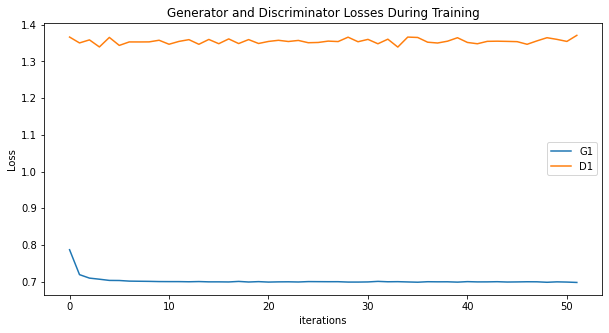

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Losses During Training")
plt.plot(G1_losses,label="G1")
plt.plot(D1_losses,label="D1")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

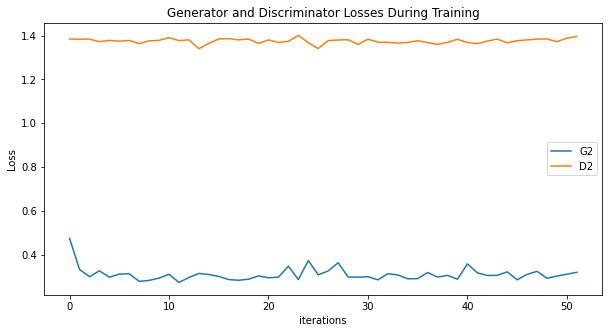

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Losses During Training")
plt.plot(G2_losses,label="G2")
plt.plot(D2_losses,label="D2")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

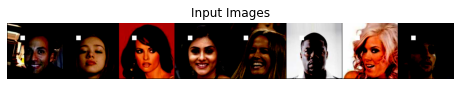

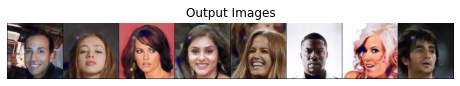

In [0]:
device = 'cpu'
Edge_generator = generator1(1).to(device)
Inpaint_generator = generator2(1).to(device)
Edge_discriminator = discriminator(2,1).to(device)
feature_matching_discriminator = discriminator(1,1).to(device)
Inpaint_discriminator = discriminator(4,1).to(device)
vgg19 = Vgg19().to(device)

Edge_generator.load_state_dict(torch.load('Edge_generator.pt'))
Inpaint_generator.load_state_dict(torch.load('Inpaint_generator.pt'))
Edge_discriminator.load_state_dict(torch.load('Edge_discriminator.pt'))
Inpaint_discriminator.load_state_dict(torch.load('Inpaint_discriminator.pt'))

Edge_generator = Edge_generator.eval().to(device)
Inpaint_generator = Inpaint_generator.eval().to(device)

rand_num = np.random.randint(60,195)
test_batch = next(iter(test_dataloader))
test_cpu = test_batch[0].to(device)
b_size = test_cpu.size(0)
I_gray = rgbtogray(test_cpu).to(device)
I_gray_masked, mask = regular_mask_grayscale(I_gray,rand_num)
I_gray_masked = I_gray_masked.to(device)
mask = mask.to(device)

r = test_cpu[:,0,:,:].unsqueeze_(1).to(device)
g = test_cpu[:,1,:,:].unsqueeze_(1).to(device)
b = test_cpu[:,2,:,:].unsqueeze_(1).to(device)

I_gt_r = np.maximum(r.cpu(),mask.cpu()).to(device)
I_gt_b = np.maximum(b.cpu(),mask.cpu()).to(device)
I_gt_g = np.maximum(g.cpu(),mask.cpu()).to(device)

I_gt_masked = torch.cat((I_gt_r,I_gt_g,I_gt_b),1).to(device) #RGB image with mask

C_gt_masked = canny_edge_detector(I_gray_masked).to(device)
edge_generator_input = torch.cat((I_gray_masked, C_gt_masked, mask),1)
C_pred = Edge_generator(edge_generator_input) ### Output after first generator

C_comp = (C_gt_masked + (torch.ones((b_size,1,256,256)).to(device)-mask) * C_pred).to(device)
generator2_input = torch.cat((I_gt_masked,C_comp),1).to(device)
I_pred = Inpaint_generator(generator2_input).to(device)



#Plot the input images with masks
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Input Images")
plt.imshow(np.transpose(vutils.make_grid(I_gt_masked.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Plot the output images
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Output Images")
plt.imshow(np.transpose(vutils.make_grid(I_pred.detach().to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

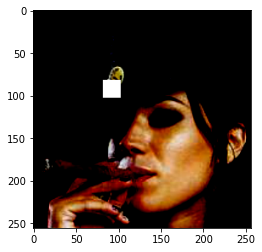

In [0]:
plt.imshow(np.transpose(I_gt_masked[5].cpu().detach(),(1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


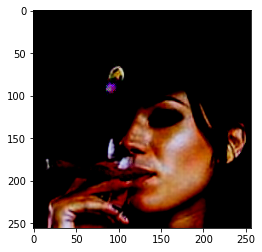

In [0]:
plt.imshow(np.transpose(I_pred[5].cpu().detach(),(1,2,0)))

In [0]:
device = 'cuda'
Edge_generator = generator1(1).to(device)
Inpaint_generator = generator2(1).to(device)
Edge_discriminator = discriminator(2,1).to(device)
feature_matching_discriminator = discriminator(1,1).to(device)
Inpaint_discriminator = discriminator(4,1).to(device)
vgg19 = Vgg19().to(device)




Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


<All keys matched successfully>